# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
import os
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

/home/jupyter-st125066/.local/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


('3.4.1', '4.36.2', '2.2.0+cu121')

In [3]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading English Hate Speech Superset

This dataset is a superset (N=360,493) of posts annotated as hateful or not. It results from the preprocessing and merge of all available English hate speech datasets in April 2024. These datasets were identified through a systematic survey of hate speech datasets conducted in early 2024. 

The dataset contains six columns:

- text: the annotated post
- labels: annotation of whether the post is hateful (== 1) or not (==0).
- source: origin of the data (e.g., Twitter)
- dataset: dataset the data is from (see "Datasets" part below)
- nb_annotators: number of annotators by post
- post_author_country_location: post author country location, when it could be inferred. 

In [4]:
raw_datasets = datasets.load_dataset('manueltonneau/english-hate-speech-superset')


In [5]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'source', 'dataset', 'nb_annotators', 'post_author_country_location'],
        num_rows: 360493
    })
})

In [6]:
raw_datasets['train'].features

{'text': Value(dtype='string', id=None),
 'labels': Value(dtype='float64', id=None),
 'source': Value(dtype='string', id=None),
 'dataset': Value(dtype='string', id=None),
 'nb_annotators': Value(dtype='string', id=None),
 'post_author_country_location': Value(dtype='string', id=None)}

In [7]:
from datasets import ClassLabel
class_names = ["no_hate", "hate"]
features = raw_datasets['train'].features.copy()
features["labels"] = ClassLabel(names=class_names)
# print(features)
raw_datasets = raw_datasets.cast(features)

In [8]:
raw_datasets['train'].features['labels']

ClassLabel(names=['no_hate', 'hate'], id=None)

In [9]:
raw_datasets['train'][0]['labels']

1

In [10]:
set(raw_datasets['train']['source'])

{'Facebook/YouTube',
 'Fox News',
 'Gab',
 'Gab + Reddit',
 'NGO',
 'Parler',
 'Reddit',
 'Stormfront',
 'Twitter',
 'Twitter + Facebook',
 'Twitter + Gab',
 'Twitter + Reddit + YouTube',
 'YouTube + Reddit',
 'synthetic'}

In [11]:
raw_datasets = raw_datasets["train"].train_test_split(train_size=0.3, seed=SEED)["train"]
splits = raw_datasets.train_test_split(test_size=0.2, seed=SEED)
train_dataset = splits["train"]
temp_split = splits["test"].train_test_split(test_size=0.5, seed=SEED)
val_dataset = temp_split["train"]
test_dataset = temp_split["test"]

In [12]:
train_dataset

Dataset({
    features: ['text', 'labels', 'source', 'dataset', 'nb_annotators', 'post_author_country_location'],
    num_rows: 86517
})

In [13]:
val_dataset

Dataset({
    features: ['text', 'labels', 'source', 'dataset', 'nb_annotators', 'post_author_country_location'],
    num_rows: 10815
})

In [14]:
raw_datasets = datasets.DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

In [15]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'source', 'dataset', 'nb_annotators', 'post_author_country_location'],
        num_rows: 86517
    })
    validation: Dataset({
        features: ['text', 'labels', 'source', 'dataset', 'nb_annotators', 'post_author_country_location'],
        num_rows: 10815
    })
    test: Dataset({
        features: ['text', 'labels', 'source', 'dataset', 'nb_annotators', 'post_author_country_location'],
        num_rows: 10815
    })
})

In [16]:
set(raw_datasets['train']['labels'])

{0, 1}

In [17]:
next(iter(raw_datasets['train']))

{'text': '[Alinity wants to kill herself]([URL] I hope all you stupid fucks stop this shit. This is bullying.',
 'labels': 0,
 'source': 'Gab + Reddit',
 'dataset': 'EDOS',
 'nb_annotators': '3',
 'post_author_country_location': 'unknown'}

In [18]:
raw_datasets['train'].features['labels']

ClassLabel(names=['no_hate', 'hate'], id=None)

In [19]:
label2id = {'no_hate': 0, 'hate': 1}
label2id

{'no_hate': 0, 'hate': 1}

In [20]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'no_hate', 1: 'hate'}

## 2. Model & Tokenization

In [21]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['labels']).size
num_labels

2

<img src = "figures/BERT_embed.png" width=500>

In [22]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

/home/jupyter-st125066/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jupyter-st125066/.local/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/jupyter-st125066/.local/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing 

In [23]:
def tokenize_function(examples):
    result = tokenizer( examples["text"], max_length=128, truncation=True)
    return result

In [24]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'source', 'dataset', 'nb_annotators', 'post_author_country_location', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 86517
    })
    validation: Dataset({
        features: ['text', 'labels', 'source', 'dataset', 'nb_annotators', 'post_author_country_location', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10815
    })
    test: Dataset({
        features: ['text', 'labels', 'source', 'dataset', 'nb_annotators', 'post_author_country_location', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10815
    })
})

In [25]:
#remove column : 'text', 'source', 'dataset', 'nb_annotators', 'post_author_country_location'
tokenized_datasets = tokenized_datasets.remove_columns(['text', 'source', 'dataset', 
                                                        'nb_annotators', 'post_author_country_location'])
#rename column : 'labels'
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 86517
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10815
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10815
    })
})

In [26]:
tokenized_datasets['train'][0]['labels']

tensor(0)

In [27]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101,  1031,  4862, 22758,  4122,  2000,  3102,  2841,  1033,  1006,
         1031, 24471,  2140,  1033,  1045,  3246,  2035,  2017,  5236,  6616,
         2015,  2644,  2023,  4485,  1012,  2023,  2003, 18917,  1012,   102])

In [28]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] [ alinity wants to kill herself ] ( [ url ] i hope all you stupid fucks stop this shit. this is bullying. [SEP]'

## 4. Preparing the dataloader

In [35]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [37]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    tokenized_datasets['train'], shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    tokenized_datasets['test'], batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    tokenized_datasets['validation'], batch_size=32, collate_fn=data_collator)

In [36]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


(torch.Size([32]), torch.Size([32, 124]), torch.Size([32, 124]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [37]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "no_hate",
    "1": "hate"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "hate": 1,
    "no_hate": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [38]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [39]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [40]:
configuration 

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "no_hate",
    "1": "hate"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "hate": 1,
    "no_hate": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [41]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.
- layer_selection is for selecting even or odd layers to be copied.

In [42]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher : Module,
    student : Module,
    layer_selection = "even"
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            teacher_idx = 2*i if layer_selection == "even" else 2*i + 1
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[teacher_idx].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return student

In [43]:
even_student = distill_bert_weights(teacher=teacher_model, student=model, layer_selection="even")

In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(even_student))

Teacher parameters : 109483778
Student parameters : 66956546


In [45]:
count_parameters(model)/count_parameters(teacher_model) * 100

61.156590705154514

In [46]:
#It has 40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [47]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [48]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [33]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [50]:
model = model.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [44]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [52]:
# !pip3 install evaluate

In [53]:
import numpy as np
import evaluate
# # Get the metric function
# if task_name is not None:
#     metric = evaluate.load("glue", task_name)
# else:
metric = evaluate.load("accuracy")

In [54]:
for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        print(batch.keys())
        model(**batch)
        break

dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])


## 9. Train

In [71]:
import torch
from tqdm.auto import tqdm
def train_fucntion(model):
    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0
    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    model = model.to(device)
    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # compute student output
            outputs = model(**batch) 
            # compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)
    
            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # cls loss 
            loss_cls  = outputs.loss
            train_loss_cls += loss_cls.item()
            # distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()
            
            # Average the loss and return it
            loss = (loss_cls + loss_div + loss_cos) / 3
            
            train_loss += loss.item()
            loss.backward()
            # accelerator.backward(loss)
            # Step with optimizer
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            
        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))
    
        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
        
        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                
            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)
    
            eval_loss += loss_cls.item()
            # predictions, references = accelerator.gather((predictions, batch["labels"]))
            metric.add_batch(
                predictions=predictions, 
                references=batch["labels"])
            
        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy'] 
        eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
        
        print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
        
    print('Avg Metric', eval_metrics/num_epochs)

    return train_losses, train_losses_cls, train_losses_div, train_losses_cos, eval_losses, eval_metrics/num_epochs

In [42]:
def test_fucntion(model):
    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0
    model = model.to(device)
    eval_loss = 0
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics = eval_metric['accuracy'] 
    eval_loss = eval_loss / len(test_dataloader)  # Save the evaluation loss for plotting
        
    print('Test Accuracy', eval_metrics)
    print('Test Losss', eval_loss)

    return eval_metrics,eval_loss

In [ ]:
# !mkdir ./even_student
# !mkdir ./odd_student
# !mkdir ./LoRA_model

### Training the student model with even layers' weights(6 layers) from the teacher model(12 layers)

In [57]:
train_losses_es, train_losses_cls_es, train_losses_div_es, train_losses_cos_es, eval_losses_es, val_acc_es = train_fucntion(model=even_student)

  0%|          | 0/13520 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.2140:
  - Loss_cls: 0.5238
  - Loss_div: 0.0695
  - Loss_cos: 0.0488
Epoch at 1: Test Acc 0.8348
Epoch at 2: Train loss 0.2014:
  - Loss_cls: 0.4718
  - Loss_div: 0.0870
  - Loss_cos: 0.0453
Epoch at 2: Test Acc 0.8385
Epoch at 3: Train loss 0.1898:
  - Loss_cls: 0.4208
  - Loss_div: 0.1046
  - Loss_cos: 0.0441
Epoch at 3: Test Acc 0.8166
Epoch at 4: Train loss 0.1809:
  - Loss_cls: 0.3810
  - Loss_div: 0.1186
  - Loss_cos: 0.0432
Epoch at 4: Test Acc 0.8264
Epoch at 5: Train loss 0.1762:
  - Loss_cls: 0.3603
  - Loss_div: 0.1259
  - Loss_cos: 0.0425
Epoch at 5: Test Acc 0.8170
Avg Metric 0.8266481738326398


In [59]:
even_student.save_pretrained("./even_student")
tokenizer.save_pretrained("./even_student")

('./even_student/tokenizer_config.json',
 './even_student/special_tokens_map.json',
 './even_student/vocab.txt',
 './even_student/added_tokens.json',
 './even_student/tokenizer.json')

In [60]:
even_student.push_to_hub("even_student", use_temp_dir=False)
tokenizer.push_to_hub("even_student")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kaung-nyo-lwin/even_student/commit/9fbc90a372e9b9cb9b85bf9b0c0670a8606a2e75', commit_message='Upload tokenizer', commit_description='', oid='9fbc90a372e9b9cb9b85bf9b0c0670a8606a2e75', pr_url=None, repo_url=RepoUrl('https://huggingface.co/kaung-nyo-lwin/even_student', endpoint='https://huggingface.co', repo_type='model', repo_id='kaung-nyo-lwin/even_student'), pr_revision=None, pr_num=None)

In [63]:
test_acc_es,test_loss_es = test_fucntion(even_student)

  0%|          | 0/13520 [00:00<?, ?it/s]

Test Accuracy 0.8182154415164123
Test Losss 0.4921612816273108


In [69]:
import json
even_student_result = {
                    "train_loosess":train_losses_es, 
                    "train_loosess_cls":train_losses_cls_es, 
                    "train_loosess_div":train_losses_div_es, 
                    "train_loosess_cos":train_losses_cos_es, 
                    "val_acc" : val_acc_es,
                    "eval_losses":eval_losses_es,
                    "test_acc": test_acc_es,
                    "test_loss": test_loss_es
}

with open("even_student_result.json", "w") as file:
    json.dump(even_student_result, file, indent=4)


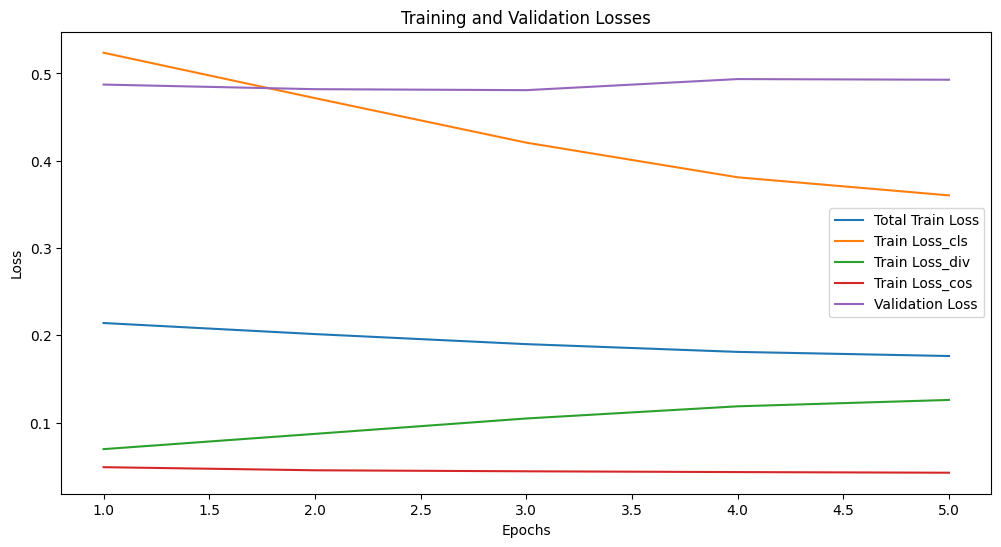

In [70]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_es, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_es, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_es, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_es, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_es, label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Training the student model with odd layers' weights(6 layers) from the teacher model(12 layers)

In [72]:
odd_student = distill_bert_weights(teacher=teacher_model, student=model, layer_selection="odd")
train_losses_os, train_losses_cls_os, train_losses_div_os, train_losses_cos_os, eval_losses_os,val_acc_os = train_fucntion(model=odd_student)

  0%|          | 0/13520 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.2138:
  - Loss_cls: 0.5225
  - Loss_div: 0.0700
  - Loss_cos: 0.0487
Epoch at 1: Test Acc 0.8278
Epoch at 2: Train loss 0.2013:
  - Loss_cls: 0.4715
  - Loss_div: 0.0873
  - Loss_cos: 0.0453
Epoch at 2: Test Acc 0.8314
Epoch at 3: Train loss 0.1900:
  - Loss_cls: 0.4213
  - Loss_div: 0.1047
  - Loss_cos: 0.0440
Epoch at 3: Test Acc 0.8286
Epoch at 4: Train loss 0.1810:
  - Loss_cls: 0.3811
  - Loss_div: 0.1187
  - Loss_cos: 0.0431
Epoch at 4: Test Acc 0.8120
Epoch at 5: Train loss 0.1761:
  - Loss_cls: 0.3598
  - Loss_div: 0.1260
  - Loss_cos: 0.0424
Epoch at 5: Test Acc 0.8134
Avg Metric 0.8226537216828479


In [73]:
odd_student.save_pretrained("./odd_student")
tokenizer.save_pretrained("./odd_student")

('./odd_student/tokenizer_config.json',
 './odd_student/special_tokens_map.json',
 './odd_student/vocab.txt',
 './odd_student/added_tokens.json',
 './odd_student/tokenizer.json')

In [74]:
odd_student.push_to_hub("odd_student", use_temp_dir=False)
tokenizer.push_to_hub("odd_student")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kaung-nyo-lwin/odd_student/commit/15b832c79f025bbc05b7112b5fcf42132b813b53', commit_message='Upload tokenizer', commit_description='', oid='15b832c79f025bbc05b7112b5fcf42132b813b53', pr_url=None, repo_url=RepoUrl('https://huggingface.co/kaung-nyo-lwin/odd_student', endpoint='https://huggingface.co', repo_type='model', repo_id='kaung-nyo-lwin/odd_student'), pr_revision=None, pr_num=None)

In [75]:
test_acc_os,test_loss_os = test_fucntion(even_student)

  0%|          | 0/13520 [00:00<?, ?it/s]

Test Accuracy 0.8168284789644013
Test Losss 0.4927501383970475


In [76]:
import json
odd_student_result = {
                    "train_loosess":train_losses_os, 
                    "train_loosess_cls":train_losses_cls_os, 
                    "train_loosess_div":train_losses_div_os, 
                    "train_loosess_cos":train_losses_cos_os, 
                    "val_acc" : val_acc_os,
                    "eval_losses":eval_losses_os,
                    "test_acc": test_acc_os,
                    "test_loss": test_loss_os
}

with open("odd_student_result.json", "w") as file:
    json.dump(odd_student_result, file, indent=4)

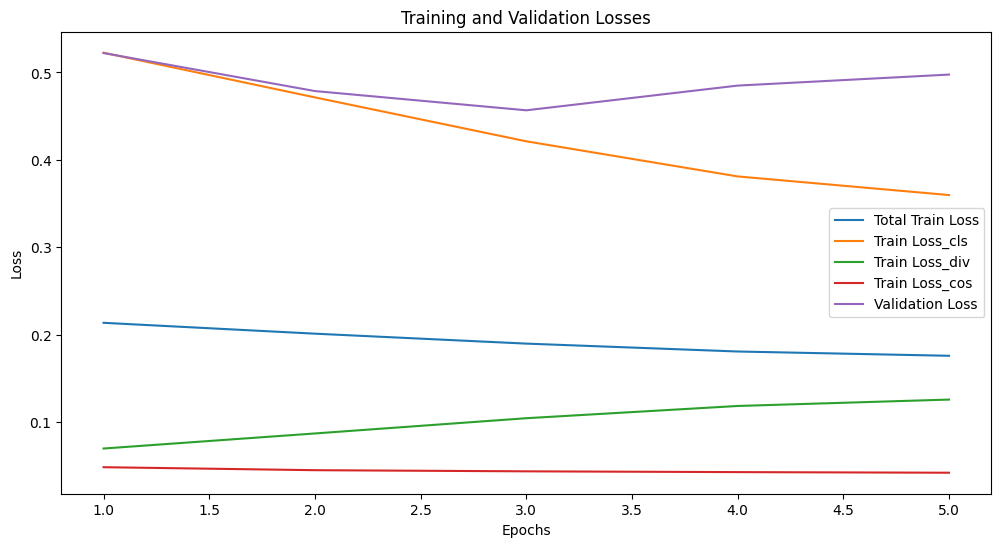

In [77]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_os, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_os, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_os, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_os, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_os, label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Training the student model(12 layers) with LoRA

In [29]:
from peft import LoraConfig, TaskType, get_peft_model
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    inference_mode=False, 
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.1,
    bias="none",
)

LoRA_model = get_peft_model(teacher_model, peft_config)
LoRA_model.print_trainable_parameters()

trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700395193203643


In [31]:
import evaluate
metric = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # preds have the same shape as the labels, after the argmax(-1) has been calculated
    # by preprocess_l"ogits_for_metrics but we need to shift the labels
    labels = labels[:, 1:].reshape(-1)
    preds = preds[:, :-1].reshape(-1)
    return metric.compute(predictions=preds, references=labels)

In [39]:
import transformers
from transformers import TrainingArguments, Trainer, default_data_collator

training_args = TrainingArguments(
    output_dir="./LoRA_model",
    learning_rate=lr,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    # load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model=LoRA_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model()
LoRA_model.save_pretrained("LoRA_model")

Step,Training Loss
500,0.428600
1000,0.416800
1500,0.410700
2000,0.406700
2500,0.399900
3000,0.399200


Checkpoint destination directory ./LoRA_model/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/home/jupyter-st125066/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Checkpoint destination directory ./LoRA_model/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/home/jupyter-st125066/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Checkpoint destination directory ./LoRA_model/checkpoint-1500 already exists and is non-empty.Saving 

In [41]:
LoRA_model.push_to_hub("LoRA_model", use_temp_dir=False)
tokenizer.push_to_hub("LoRA_model")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/kaung-nyo-lwin/LoRA_model/commit/aa21ee4386f36993798dc13943cf47c1d815133e', commit_message='Upload tokenizer', commit_description='', oid='aa21ee4386f36993798dc13943cf47c1d815133e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/kaung-nyo-lwin/LoRA_model', endpoint='https://huggingface.co', repo_type='model', repo_id='kaung-nyo-lwin/LoRA_model'), pr_revision=None, pr_num=None)

In [45]:
test_acc_lora,test_loss_lora = test_fucntion(LoRA_model)

  0%|          | 0/13520 [00:00<?, ?it/s]

Test Accuracy 0.8099861303744799
Test Losss 0.4188197352124389


## 10. Evaluation and Discussion

### Evaluation Results

In [46]:
import pandas as pd
pd.DataFrame({
    "Model Type" : ["Odd Layer", "Even Layer", "LoRA"],
    "Training Loss" : [0.17606847337584877, 0.17623400936156688,0.399200],
    "Test Loss": [0.4927501383970475,0.4921612816273108,0.4188197352124389],
    "Test Accuracy" : [0.8168284789644013, 0.8182154415164123, 0.8099861303744799]
})

,Model Type,Training Loss,Test Loss,Test Accuracy
0,Odd Layer,0.176068,0.492750,0.816828
1,Even Layer,0.176234,0.492161,0.818215
2,LoRA,0.399200,0.418820,0.809986


### Inference

In [56]:
# Inference
from transformers import pipeline
classifier = pipeline("text-classification", model="kaung-nyo-lwin/even_student")
classifier("you, gay, nigger")

/home/jupyter-st125066/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[{'label': 'hate', 'score': 0.7527675032615662}]

### Discussion

In terms of training loss, the distillation models (both odd and even) are twice as good as LoRA models(12 layers). However, significant performance differences are not observed on the test set although there is still a small margin for better loss and accuracy (test) in the distillation models.

There are three different losses in distillation models, in which the KL divergence loss needs to be implemented from scratch. Then, selecting and copying the weights from larger models to smaller models needs a little bit more effort than usual. These two will be the main challenges in implementing distillation models. On the other hand, since the peft module from huggingface is used to implement LoRA, there is no similar challenge. However, there is some are dependency issues among the packages, which need to be solved for some time. Nevertheless, These challenges in implementation are solvable although there are some modifications like creating classes for more efficiency.

Regarding the performances of the models, although the distillation fine-tuning is better, these models seem to overfit as the test set performances are that much different. Hence, training more iteration will not help the performances. On the other hand, training more iterations with LoRA might achieve the better performances. Finally, I have trained the models with only 100k data of overall 300k data due to computational resources. Increasing the data size will help the performances